In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import pandas as pd
import glob
import datetime

from utils import TrainingSetManager
from utils import TeenmagiDataset

import time

import random
from random import shuffle
import math

import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import initializers
from tensorflow.keras import backend as K

import imgaug as ia
import imgaug.augmenters as iaa

from os import walk
import pickle
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from tempfile import TemporaryFile

from IPython.display import clear_output
from tqdm.notebook import tqdm

In [2]:
training_set_manager = TrainingSetManager()
print(len(training_set_manager.validation_x))

Loaded grayscaled datasets
48238


In [3]:
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Correlation identification

In [4]:
categories = [i+1 for i in range(10)]
reindices = [0]

corr_areas = [[],#385, 359, 230, 250, 300, 602, 677],
              [],#440, 369, 250, 300, 320, 652, 730]
             ]

sometimes = lambda aug: iaa.Sometimes(1, aug)

seq = iaa.Sequential([
    sometimes(
        iaa.CropAndPad( px=(-2, 2), pad_mode=ia.ALL, pad_cval=(0, 0))
    ),
])

def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.ylim(0,1)
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [5]:
# Model
# - Chance to from_logits to False

initializer = lambda : initializers.RandomUniform(minval=-2, maxval=2)

dense_layer = lambda x, y : layers.Dense(x, activation=y,
                                               kernel_initializer=initializer(),
                                               bias_initializer=initializer(),
                                              )

conv2d_layer = lambda filters : layers.Conv2D(
                            filters, (3,3), padding='same', activation='relu',
                            #kernel_initializer=initializer(),
                            #bias_initializer=initializer()
                            )

class LRFind(tf.keras.callbacks.Callback): 
    def __init__(self, min_lr, max_lr, n_rounds): 
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = (max_lr / min_lr) ** (1 / n_rounds)
        self.lrs = []
        self.losses = []
     
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr

    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs["loss"])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)
        
def CropPad(x):
    if np.random.rand() <= 0.1:
        c = np.random.randint(1,3)
        if np.random.rand() <= 0.5:
            x = tf.keras.layers.Cropping2D(cropping=((c, c), (0, 0)))(x)
            x = tf.keras.layers.ZeroPadding2D(padding=((c, c), (0, 0)))(x)
        else:
            x = tf.keras.layers.Cropping2D(cropping=((0, 0), (c, c)))(x)
            x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (c, c)))(x)
    return x

In [6]:
class MasterModel(Model):
    def __init__(self, augmentation=True, name=None, output_size=1000):
        super(MasterModel, self).__init__(name=name)
        
        self.augmentation = augmentation
        
        self.data_augmentation = tf.keras.Sequential(
          [
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.Lambda(CropPad),
          ]
        )
        
        self.base_model = tf.keras.Sequential([
            layers.Input(shape=(8, 8, 1)),
            layers.Conv2D(64, (3,3), padding='same', activation='gelu'),
            layers.MaxPooling2D(),
            
            layers.Flatten(),
            layers.Dropout(0.2),
            dense_layer(512, 'gelu'),
            
            layers.Dense(output_size)        
        ])
            
    def test_step(self, data):
        print("\ntest_step")
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self.call_eval(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
            
    def call_eval(self, x, training=False):
        x = self.base_model(x, training=training)
        return x
            
    def call(self, x, training=True):
        #x = self.input_layer(x)
        if self.augmentation:
            x = self.data_augmentation(x, training=training)
        x = self.base_model(x, training=training)
        return x

MODEL_COUNT = 1
FROM_LOGITS = True
SPARSE      = False

CATEGORYS_PER_STEP = int(1000/MODEL_COUNT)
model_name = "correlation_" + str(MODEL_COUNT)
tmp = glob.glob("models/" + model_name + "*")
model_name = model_name + "_" + str(len(tmp)) + "_test"
MODEL_PATH = "models/correlation_" + str(MODEL_COUNT) + ("_SPARSE" if SPARSE else "_NSPARSE") + "/"

tmp_teenmagi_dataset = TeenmagiDataset(
                                   #categories=categories, 
                                   batch_size=128, 
                                   n_valid=100,
                                   sparse=SPARSE,
                                   use_area=False,
                                   #zero_percentage=.3,
                                  )
OUTPUT_SIZE = tmp_teenmagi_dataset.output_size #CATEGORYS_PER_STEP + (0 if MODEL_COUNT==1 else 1)
print("Output size:", OUTPUT_SIZE)

models = []
for i in range(MODEL_COUNT):
    model_name ="correlation_" + str(i + 1) + "_master"
    tmp_model = MasterModel(name=model_name, 
                            output_size=tmp_teenmagi_dataset.output_size#OUTPUT_SIZE
                           )
    
    tmp_model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    models.append(tmp_model)
            
#models[0].summary()

Output size: 1001


In [9]:
START_MODEL_I = 0 #54

for i in range(START_MODEL_I, len(models)):
    #model_name ="correlation_" + str(i + 1)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='accuracy', 
                                                  factor=0.7,
                                                  patience=4,
                                                  min_lr=1e-4, 
                                                  verbose=0,
                                                  min_delta=0.02,
                                                  cooldown=4,
                                                )

    model_weight_path =  MODEL_PATH + models[i].name
    print(model_weight_path)
    
    early_stopping = keras.callbacks.EarlyStopping(patience=6, monitor='accuracy')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_weight_path, save_best_only=True, monitor='accuracy', verbose=0)
    
    model_checkpoint_val = tf.keras.callbacks.ModelCheckpoint(
        model_weight_path + "_val", save_best_only=True, monitor='val_accuracy', verbose=0)
    
    start = i * CATEGORYS_PER_STEP + 1
    end = start + CATEGORYS_PER_STEP
    categories = [i for i in range(start, end)]
    
    print("Model", i + 1, "-", models[i].name)
    print(" categories from", categories[0], "to", categories[-1])
    
    """
    (termi_train, termi_valid, termi_test) =\
        training_set_manager.gen_training_set(
            categories=categories,
            category_sizes    =1000,
            category_zero_size=1000,
            plot=True,
            #n_augmentation=100,
            n_valid=100,
            n_test=1,
            )
    """

    teenmagi_dataset = TeenmagiDataset(#categories=categories, 
                                       batch_size=128, 
                                       n_valid=100,
                                       sparse=SPARSE,
                                       use_area=False,
                                       #zero_percentage=.3,
                                      )

    #K.set_value(models[i].optimizer.learning_rate, 1e-4)
    
    first_time = datetime.datetime.now()
    history = models[i].fit(teenmagi_dataset,
                            #termi_train[0], termi_train[1], 
                                   epochs=20,
                                   #validation_data=teenmagi_dataset.validation_set(only_categories=False),
                                   #steps_per_epoch=400,
                                   #verbose=0,
                                      callbacks=[
                                           reduce_lr,
                                           early_stopping,
                                           #model_checkpoint,
                                           #model_checkpoint_val,
                                       ])
    evaluate_set = teenmagi_dataset.validation_set(only_categories=True)
    a,b = evaluate_set
    models[i].evaluate(a, b)

    plot_history(history)
    difference = datetime.datetime.now() - first_time
    print("  stopped at epoch", len(history.history['accuracy']))
    print("  latest accuracy:", history.history['accuracy'][-1])
    if 'val_accuracy' in history.history:
        print("  best val_accuracy:", max(history.history['val_accuracy']))
    print("  time left est:", (len(models) - i) * difference)
    #teenmagi_dataset.info()

models/correlation_1_NSPARSE/correlation_1_master
Model 1 - correlation_1_master
 categories from 1 to 1000
Epoch 1/20
10000/10000 [==============================] - 137s 13ms/step - loss: 6.5810 - accuracy: 0.0098 - lr: 0.0010
Epoch 2/20
10000/10000 [==============================] - 157s 16ms/step - loss: 6.4313 - accuracy: 0.0150 - lr: 0.0010
Epoch 3/20
  668/10000 [=>............................] - ETA: 2:24 - loss: 6.3939 - accuracy: 0.0172 ETA: 2:26 - l - ETA: 2:22 - loss:

KeyboardInterrupt: 

In [ ]:
accuracies = []
for i, tmp_model in enumerate(models):
    start = i * CATEGORYS_PER_STEP + 1
    end = start + CATEGORYS_PER_STEP
    categories = [i for i in range(start, end)]
    
    teenmagi_dataset = TeenmagiDataset(categories=categories, 
                                   batch_size=64, 
                                   n_valid=100,
                                   sparse=SPARSE,
                                   #zero_percentage=0.2
                                  )
    (x, y) = teenmagi_dataset.validation_set(only_categories=True)
    [loss, accuracy] = tmp_model.evaluate(x, y, verbose=0)
    accuracies.append(accuracy)
    print("Model:", i, "- accuracy:", round(accuracy, 4) , "- loss:", loss)

print("Total accuracy:", sum(accuracies)/len(accuracies))

In [ ]:
models[0]

### - Confusion matrix plotting

In [12]:
#(_, confusion_set, _) = (termi_train, termi_valid, termi_test) #training_set_manager.gen_training_set(
        #categories=[i+1 for i in range(1000)],
    #)
#training_set_manager.plot(confusion_set[1])
confusion_set = teenmagi_dataset.validation_set(only_categories=False)
a,b = confusion_set
#models[i].evaluate(a, b)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [41]:
predictions = models[i].predict(a) #models[0].predict(confusion_set[0])
predictions_arg = tf.argmax(predictions, axis=-1)
print(len(predictions[0]))
print(predictions_arg)

1000
tf.Tensor([189 665 254 ... 661 839 960], shape=(100000,), dtype=int64)


In [42]:
confusion_mtx = tf.math.confusion_matrix(tf.argmax(b, axis=-1), predictions_arg)
confusion_mtx = confusion_mtx.numpy() #np.amax(predictions_arg)
#confusion_mtx[confusion_mtx < 0.4] = 0
print(confusion_mtx.shape)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

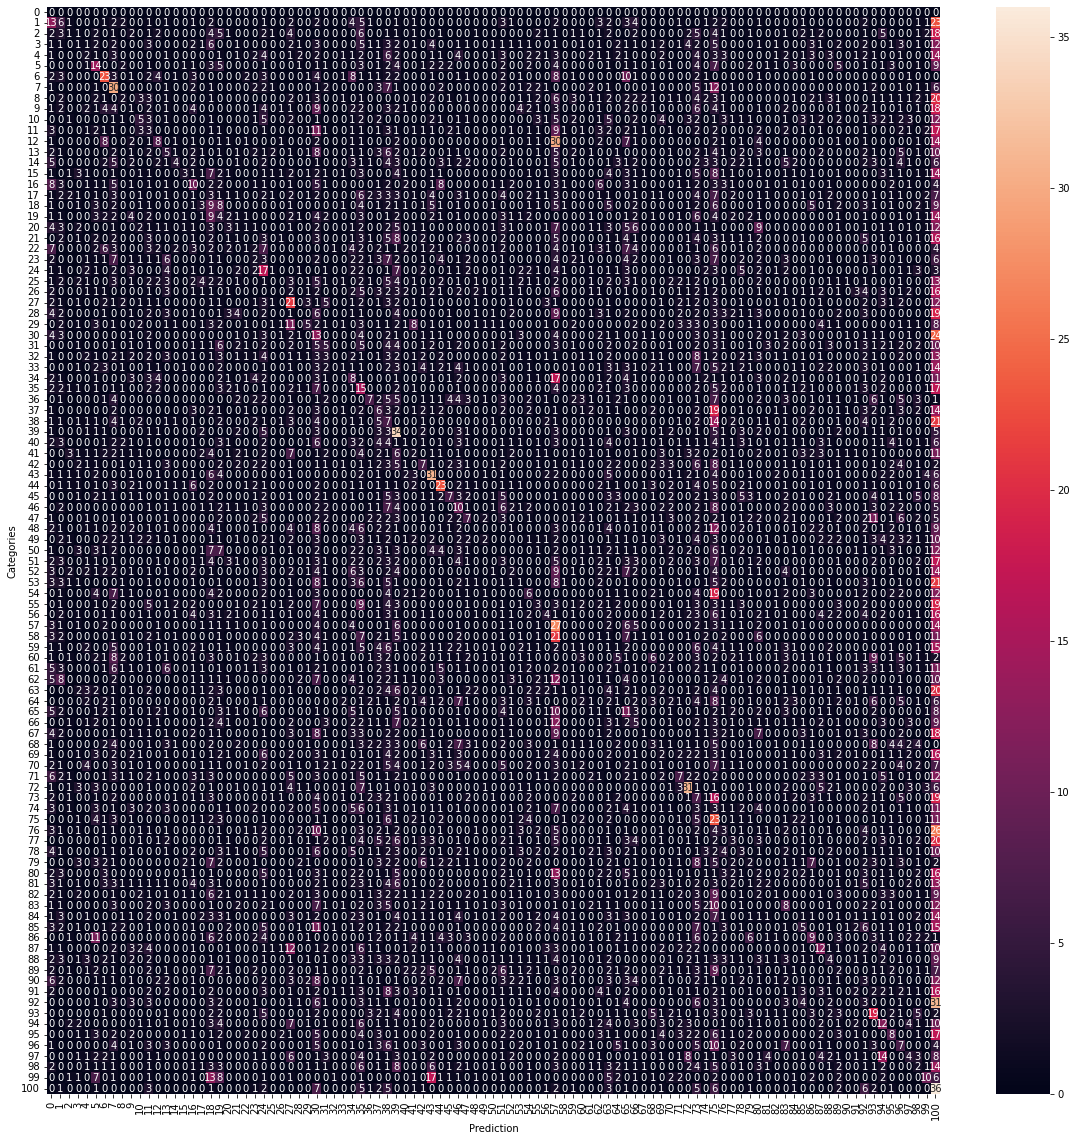

In [64]:
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Categories')
    plt.show()
    
confusion_mtx = confusion_mtx
show_confusion_matrix(confusion_mtx, [i for i in range(OUTPUT_SIZE)])

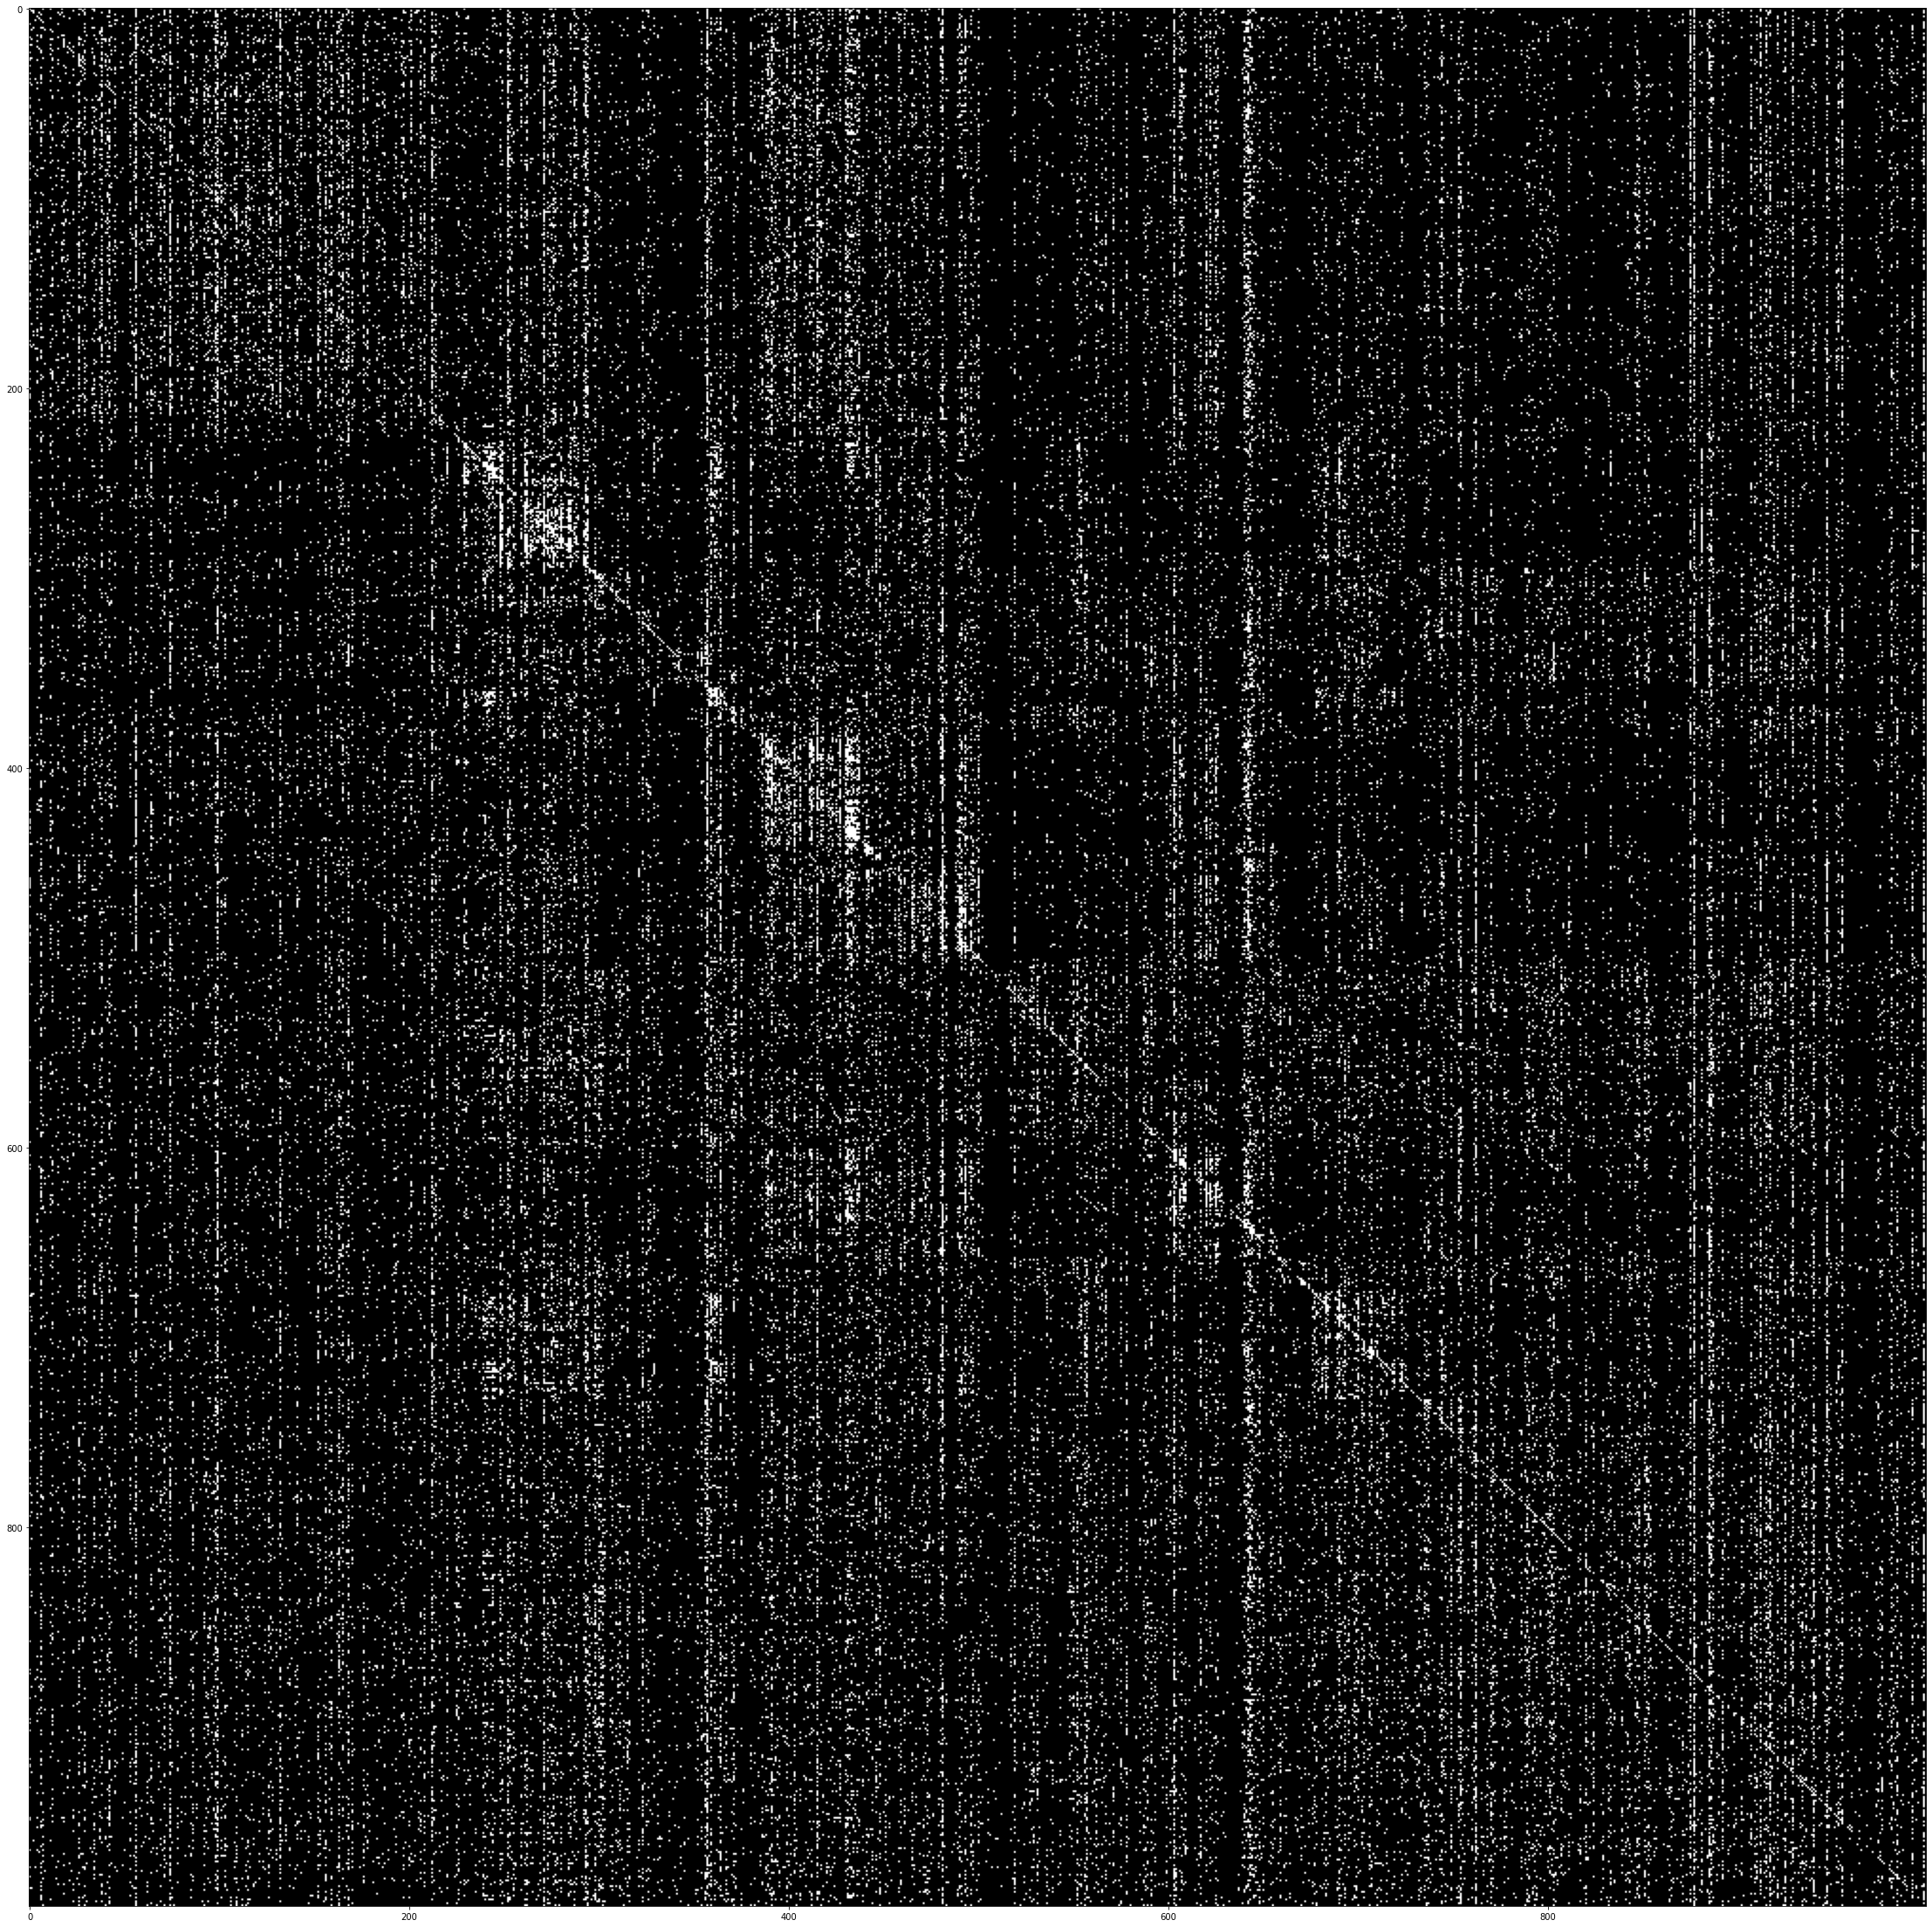

In [16]:
heatmap_filepath = "heatmaps/heatmap_" + str(OUTPUT_SIZE)
cconfusion_mtx = confusion_mtx / 1
cconfusion_mtx = np.clip(cconfusion_mtx, a_min=0, a_max=1)

img = cconfusion_mtx# np.rot90(confusion_mtx, k=1, axes=(0, 1)) # /asd #* 255
img = np.reshape(img, (OUTPUT_SIZE, OUTPUT_SIZE))

tmp = glob.glob(heatmap_filepath + "*")
plt.figure(figsize=(40, 40))

matplotlib.image.imsave(heatmap_filepath + "_" + str(len(tmp)) + ".png", img)

plt.imshow(img)
plt.gray()
#plt.savefig(heatmap_filepath + "_" + str(len(tmp)) + ".png")

# Combined Model

In [10]:
correlation_models = [2, 25]

TRAINABLE=False
C_SPARSE = False
use_best_val = False

In [11]:
models = []
for model_size in correlation_models:
    root_folder = "models/correlation_" + str(model_size) + "_NSPARSE"
    model_paths = glob.glob(root_folder + "/*[!val]") #("/*[val]" if use_best_val else "/*[!val]") )
    print("model_size:", model_size, "found",len(model_paths))
    
    #Loading models
    for i, model_path in enumerate(tqdm(model_paths)):
        tmp_model = tf.keras.models.load_model(model_path)
        tmp_model._name = "correlation_" + str(model_size) + "_" + str(i)
        tmp_model.trainable = TRAINABLE
        models.append(tmp_model)

model_size: 2 found 2


  0%|          | 0/2 [00:00<?, ?it/s]

model_size: 25 found 25


  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
#models = models[:50]

# SETTINGS
MODEL_COUNT_TERMI = len(models)
CATEGORYS_PER_STEP_TERMI = int(1000/MODEL_COUNT_TERMI)

OUTPUT_SIZE = CATEGORYS_PER_STEP_TERMI*len(models) + 1 if len(models) != 100 else 1000
OUTPUT_SIZE = 1000
print("OUTPUT_SIZE:", OUTPUT_SIZE)

OUTPUT_SIZE: 1000


In [14]:
# Input
image_input = keras.Input(shape=(8,8,1), name="image")
outputs = []

for model in models:
    x = model(image_input, training=TRAINABLE)
    outputs.append(x)
    
x = layers.concatenate(outputs)

#x=layers.Dropout(0.2)(x)
#x=layers.Dense(64, activation='relu', kernel_regularizer='l1_l2')(x)
x=layers.Dense(1000, use_bias=False, activation='relu')(x)
#x=layers.Dense(1000, activation='relu')(x)

output = layers.Dense(OUTPUT_SIZE, use_bias=False)(x)

model_terminator = keras.Model(inputs=image_input, outputs=output, name="terminator_classifier")

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_terminator.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

try:
    model_terminator = tf.keras.models.load_model("models/terminator_" + str(correlation_models[0]) + "_latest")
    print("Model loaded")
except:
    pass

model_terminator.summary()

Model loaded
Model: "terminator_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 correlation_2_0 (Functional)   (None, 501)          782453      ['image[0][0]']                  
                                                                                                  
 correlation_2_1 (Functional)   (None, 501)          782453      ['image[0][0]']                  
                                                                                                  
 correlation_25_0 (Functional)  (None, 41)           273577      ['image[0][0]']                  
                                                                 

In [18]:
def set_trainability(model): # Takes keras Model and dictionary with layer names and booleans indicating the desired trainability of the layer. 
                                         # modifies model so that every Layer in the Model, whose name matches dict key will get trainable = boolean
    for layer in model.layers: 
        if isinstance(layer, tf.keras.models.Model):
            set_trainability(layer)
        else: 
            layer.trainable = True
                                 
set_trainability(model_terminator)

model_terminator.summary()

Model: "terminator_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 correlation_2_0 (Functional)   (None, 501)          782453      ['image[0][0]']                  
                                                                                                  
 correlation_2_1 (Functional)   (None, 501)          782453      ['image[0][0]']                  
                                                                                                  
 correlation_25_0 (Functional)  (None, 41)           273577      ['image[0][0]']                  
                                                                              

In [19]:
termi_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='accuracy', 
                                              factor=0.6,
                                              patience=3,
                                              min_lr=1e-6, 
                                              verbose=0,
                                              min_delta=0.01,
                                              cooldown=3,
                                            )
teenmagi_dataset_comb = TeenmagiDataset(#categories=categories, 
                                        batch_size=256, 
                                        n_valid=50,
                                        sparse=False,
                                        master_model=True,
                                       #zero_percentage=0.1
                                      )

#early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor='accuracy')

model_weight_path = "models/terminator_" + str(correlation_models[0]) + "_latest"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_weight_path, save_best_only=True, monitor='accuracy', verbose=0)

K.set_value(model_terminator.optimizer.learning_rate, 1e-5)

history = model_terminator.fit(teenmagi_dataset_comb,
                               #termi_train[0], termi_train[1],                            
                               epochs=100, 
                               #validation_data=teenmagi_dataset_comb.validation_set(),
                               #steps_per_epoch=200,
                               #shuffle=True,
                               #verbose=0,          
                                  callbacks=[
                                       termi_reduce_lr,
                                       #early_stopping,
                                       model_checkpoint,
                                       ]
                       )

# 0.0457
# 0,0481

Epoch 1/100


InvalidArgumentError: 2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: 'a' cannot be empty unless no samples are taken
Traceback (most recent call last):

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\script_ops.py", line 275, in __call__
    ret = func(*args)

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\keras\engine\data_adapter.py", line 834, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\keras\engine\data_adapter.py", line 960, in generator_fn
    yield x[i]

  File "C:\Users\panup\Coding\Tampereen Yliopisto\DATA.ML.200 Pattern Recognition and Machine Learning\teenmagi-2022\utils\teenmagi_dataset0.py", line 179, in __getitem__
    ix = np.random.choice(self.train_iset[c])

  File "mtrand.pyx", line 915, in numpy.random.mtrand.RandomState.choice

ValueError: 'a' cannot be empty unless no samples are taken


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  ValueError: 'a' cannot be empty unless no samples are taken
Traceback (most recent call last):

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\script_ops.py", line 275, in __call__
    ret = func(*args)

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\keras\engine\data_adapter.py", line 834, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\panup\AppData\Roaming\Python\Python37\site-packages\keras\engine\data_adapter.py", line 960, in generator_fn
    yield x[i]

  File "C:\Users\panup\Coding\Tampereen Yliopisto\DATA.ML.200 Pattern Recognition and Machine Learning\teenmagi-2022\utils\teenmagi_dataset0.py", line 179, in __getitem__
    ix = np.random.choice(self.train_iset[c])

  File "mtrand.pyx", line 915, in numpy.random.mtrand.RandomState.choice

ValueError: 'a' cannot be empty unless no samples are taken


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_175861]

Function call stack:
train_function -> train_function


In [28]:
predictions = training_set_manager.validate_model(model_terminator)

df = predictions[0]
tmp = np.array(df['Class'])
tmp += 1
df['Class'] = tmp
df

,Class
Id,
1,549
2,416
3,333
4,628
5,651
...,...
48234,549
48235,612
48236,665


In [29]:
df.to_csv("hello.csv")